In [9]:
import rank
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
import numpy as np
import cv2

In [ ]:
#query_path = 'datasets/Brueghel/Winter Village Landscape with Ice Skating.jpg'
#query_path = 'datasets/Brueghel/Wide Landscape with Wagon and Travelers (London).jpg'
#query_path = 'datasets/Brueghel/Winter (Braunschweig).jpg'
#query_path = '/home/annab/Durham2024/datasets/Brueghel/A Bridal Feast (Unknown).jpg'
query_path = 'datasets/Brueghel/Wide River Landscape with Resting Travelers.jpg' ##INTERSTING#
#query_path = 'datasets/Brueghel/Allegory of Air (Germany).jpg'
#query_path = 'datasets/Brueghel/Wedding Celebration in a Barn (Sotheby\'s, London 2002).jpg'
#query_path = 'datasets/Brueghel/Village Street with Dancing Peasants.jpg'
#query_path = 'datasets/Brueghel/View Down a River through a Village.jpg'
top_matches = rank.cos_sim(query_path, 'embeddings/Brueghel_conc.pkl')

In [ ]:
for query, matches in top_matches:
   print(query)
   #print(f"Query: {query['box']}")
   for match, similarity in matches:
       print(f"Match: {match['image_path'], match['box']} with similarity {similarity}")


In [2]:
import os
import json
def lookup_gt(q, detections_dir):
    query = os.path.basename(q['image_path']) 
    box = list(q['box'])
    ground_truth = []

    for detection_file in os.listdir(detections_dir):
        if os.path.splitext(detection_file)[0] ==  os.path.splitext(query)[0]:
            with open(os.path.join(detections_dir, detection_file), 'r') as f:
                detections_dict = json.load(f)
                for det in detections_dict:
                    query_box = [det['box']['x1'], det['box']['y1'], det['box']['x2'], det['box']['y2']]
                    if query_box == box:
                        ground_truth = det['global_matches']
                        category = det['category']
                        
    return (category, ground_truth)
        

In [3]:
import rank
import os
#print(top_matches)

def global_correctness(matches, true_matches, factor):
    #print(matches[0][0]['image_path'])
    count = 0
    matched_images= []
    for m in matches:
     image_name = os.path.basename(m[0]['image_path']) 
     matched_images.append(image_name)
    #print(matched_images)
    matched_images = set(matched_images[:len(true_matches)*factor])
    #print(matched_images)

    for img in true_matches:
            if img in matched_images:
                count +=1
                #print(count)
    correct_ratio = count/len(true_matches)


    return(correct_ratio)


In [4]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def draw_bounding_boxes(image_path, boxes, colors, tags=None, alpha=0, offset=2):

    image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)

    if len(image.shape) == 2:  # Grayscale image
        height, width = image.shape
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert to RGB
    else:
        height, width, _ = image.shape

    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.imshow(image)
    ax.axis('off')

    offsets = np.zeros((len(boxes), 2))  # Array to keep track of offsets applied to each box

    for i, (x1, y1, x2, y2) in enumerate(boxes):
        x1 = int(x1 * width)
        y1 = int(y1 * height)
        x2 = int(x2 * width)
        y2 = int(y2 * height)

        # Apply an offset if this box overlaps with previously drawn boxes
        for j in range(i):
            prev_x1, prev_y1, prev_x2, prev_y2 = boxes[j]
            prev_x1 = int(prev_x1 * width) + offsets[j][0]
            prev_y1 = int(prev_y1 * height) + offsets[j][1]
            prev_x2 = int(prev_x2 * width) + offsets[j][0]
            prev_y2 = int(prev_y2 * height) + offsets[j][1]

            # Check for overlap
            if (x1 < prev_x2 and x2 > prev_x1 and y1 < prev_y2 and y2 > prev_y1):
                offsets[i] = [offsets[i][0] + offset, offsets[i][1] + offset]
        
        x1 += offsets[i][0]
        y1 += offsets[i][1]
        x2 += offsets[i][0]
        y2 += offsets[i][1]

        # Draw the bounding boxes
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor=colors[i], facecolor='none',
            alpha=0.8
        )
        ax.add_patch(rect)
        
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='none', facecolor=colors[i],
            alpha=alpha
        )
        ax.add_patch(rect)

        if tags is not None:
            ax.text(
                x1, y1 - 10, f'{tags[i]}', 
                color='white', fontsize=8, 
                bbox=dict(facecolor='black', alpha=0.4, pad=1)
            )

    # To avoid displaying the plot and just get the image
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    
    # Save the plot to a buffer
    from io import BytesIO
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    
    # Read the image back from the buffer
    img_array = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    buf.close()
    
    # Convert to RGB (matplotlib uses RGB while OpenCV uses BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.close(fig)
    
    return img


In [5]:
def path_to_painting(img_path):
    filename = os.path.basename(img_path)
    return os.path.splitext(filename)[0]

In [6]:
import cv2
import os
import gc

def create_visualisations(top_matches, dirname, detections_dir):
    visualDir_path = os.path.join('results', dirname, 'visualDir')
    os.makedirs(visualDir_path, exist_ok=True)

    for query, matches in top_matches:
        cat, ground_truth = lookup_gt(query, detections_dir)
        query_folder_path = os.path.join(visualDir_path, cat, path_to_painting(query['image_path']))
        os.makedirs(query_folder_path, exist_ok=True)

        # Draw and save query image
        query_img = draw_bounding_boxes(query['image_path'], [query['box']], ['red'])
        query_file = os.path.join(query_folder_path, 'query.jpg')
        cv2.imwrite(query_file, query_img)
        
        # Explicitly delete query_img to free memory
        del query_img

        for i, match in enumerate(matches[:1]):
            m = match[0]
            s = round(match[1], 3)
            
            # Draw and save match image
            match_img = draw_bounding_boxes(m['image_path'], [m['box']], ['blue'], tags=[s])
            match_file = os.path.join(query_folder_path, f'match_{i+1}_{path_to_painting(m["image_path"])}.jpg')
            cv2.imwrite(match_file, match_img)
            
            # Explicitly delete match_img to free memory
            del match_img
        
        # Perform garbage collection
        gc.collect()

In [12]:
import os
import rank
def eval_and_save(dirName, query_embeddings_path, embeddings_path, top_n, detections_dir, categories):
    os.makedirs('results', exist_ok = True)
    dir_path = os.path.join('results', dirName)
    correct_ratio_path = os.path.join(dir_path, 'correct_ratios')

    os.makedirs(correct_ratio_path, exist_ok=True)
    
    results_dict = {}
    mean_dict = {}
    #prepare one key for each category for better comparison
    for c in categories:
        results_dict[c]= []

    top_matches = rank.rank_local_to_global(query_embeddings_path, embeddings_path, top_n)
    #create_visualisations(top_matches, visualDir_path, detections_dir)
    for matches_for_query in top_matches:
        cat, ground_truth = lookup_gt(matches_for_query[0], detections_dir)
        correct_ratio = global_correctness(matches_for_query[1], ground_truth, 1)
        correct_ratio_factor2 = global_correctness(matches_for_query[1], ground_truth, 2)
        results_dict[cat].append({
            'query' : matches_for_query[0]['image_path'],
          'correct_ratio' : correct_ratio,
          'correct_ratio_factor2' : correct_ratio_factor2
      })
        

    for cat, results in results_dict.items():
            mean_correct_ratio = np.mean([r['correct_ratio'] for r in results])
            mean_correct_ratio2 = np.mean([r['correct_ratio_factor2'] for r in results])
            mean_dict[cat] = {
                'mean_correct_ratio' : mean_correct_ratio,
                'mean_correct_ratio_factor2' : mean_correct_ratio2
            }

    general_mean = np.mean([r['mean_correct_ratio'] for r in mean_dict.values()])
    general_mean_factor2 = np.mean([r['mean_correct_ratio_factor2'] for r in mean_dict.values()])
    
    general_dict = {
                'mean_correct_ratio' : general_mean,
                'mean_correct_ratio_factor2' : general_mean_factor2
            }
    
    with open(os.path.join(correct_ratio_path, 'ratios_dict.json'), 'w') as f:
        json.dump(results_dict, f, indent=4)

    with open(os.path.join(correct_ratio_path, 'mean_ratios_dict.json'), 'w') as f:
        json.dump(mean_dict, f, indent=4)
    with open(os.path.join(correct_ratio_path, 'general_means.json'), 'w') as f:
        json.dump(general_dict, f, indent=4)

    

categories = ["888", "55", "555", "5555", "000", "0000", "11", "444", "66", "44"]

eval_and_save('breueghelTest_resenet18', 'embeddings/Brueghel_queries/resnet18/conc_pca_50.pkl', 'embeddings/Brueghel/resnet18/conc_pca_50.pkl', 150, 'object_detection/brueghelTest', categories  )      
  

(273, 36186)


In [13]:
top_matches = rank.rank_local_to_global('embeddings/Brueghel_queries/resnet18/conc_pca_50.pkl', 'embeddings/Brueghel/resnet18/conc_pca_50.pkl', 150)
create_visualisations(top_matches, 'breueghelTest_resnet18', 'object_detection/brueghelTest' )

(273, 36186)


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
## create correctness restlts for shen
with open('artminer_repro/brueghelFinetuneDet.json') as f:
    shen_res = json.load(f)
with open('brueghelTest.json_categories.json') as f:
    gt_dict = json.load(f)

for cat, images in shen_res.items():
    matches= images
    
    


## UNTTIL HERE


In [6]:


def most_matched_images(top_matches, n_images, n_boxes):
    query_path = top_matches[0][0]['image_path']
    
    counter = Counter()
    for _, matches in top_matches:
        for match_embedding_dict, _ in matches:
            counter[match_embedding_dict['image_path']] += 1

    most_common_image_paths = counter.most_common(n_images)
    print('Top matches:', most_common_image_paths)

    top_matches_on_most_common_images = []
    
    for img_path, _ in most_common_image_paths:
        matches_for_img = []
        for query_embedding_dict, matches in top_matches:
            for match_embedding_dict, similarity in matches:
                if match_embedding_dict['image_path'] == img_path:
                    matches_for_img.append((query_embedding_dict, match_embedding_dict, similarity))
        
        matches_for_img.sort(key=lambda x: x[2], reverse=True)
        top_matches_on_most_common_images.append(matches_for_img[:n_boxes])
    
    for matches in top_matches_on_most_common_images:
        query_boxes = [match[0]['box'] for match in matches]
        match_boxes = [match[1]['box'] for match in matches]
        similarities = [match[2] for match in matches]

        print(similarities)

        tags = [i for i in range(1, 100)]
        
        cmap = plt.get_cmap('coolwarm')
        colors = [cmap(similarity) for similarity in similarities]



        
        if matches:
            image_path = matches[0][1]['image_path']
            draw_bounding_boxes(query_path, query_boxes, colors, offset=5, tags = tags)
            draw_bounding_boxes(image_path, match_boxes, colors, offset=5, tags = tags)


In [ ]:
most_matched_images(top_matches, 3, 10)

In [ ]:
query_path  = "datasets/Brueghel/A Bridal Procession (Antwerp).jpg"
image = cv2.imread(query_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width, _ = image.shape

# Define the bounding box
box = [409, 37, 544, 271]

# Convert box coordinates to ratios
x_min, y_min, x_max, y_max = box

x_min_ratio = x_min / width
y_min_ratio = y_min / height
x_max_ratio = x_max / width
y_max_ratio = y_max / height

box = (x_min_ratio, y_min_ratio, x_max_ratio, y_max_ratio)
top_matches = rank.cos_sim(query_path, 'embeddings/Brueghel_conc.pkl', patch_box=box)




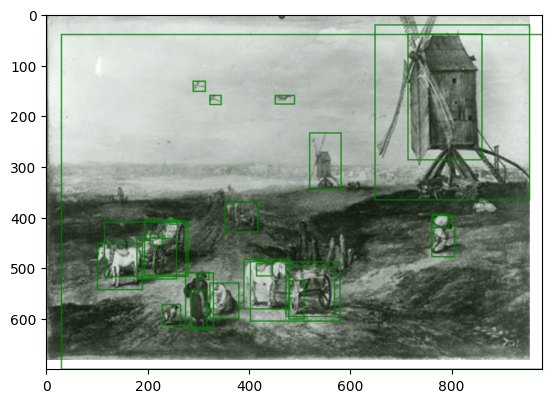

In [9]:
import json
with open('object_detection/brueg_small_detections/Windmill in a Broad Field.json', 'r') as f:
  data = json.load(f)
boxes = [item['box'] for item in data] 
t_boxes = [(b['x1'], b['y1'], b['x2'], b['y2']) for b in boxes]

colors = []

for i in range(50):
  colors.append('green')

img =draw_bounding_boxes('datasets/brueg_small/Windmill in a Broad Field.jpg', t_boxes, colors )
plt.imshow(img)

True

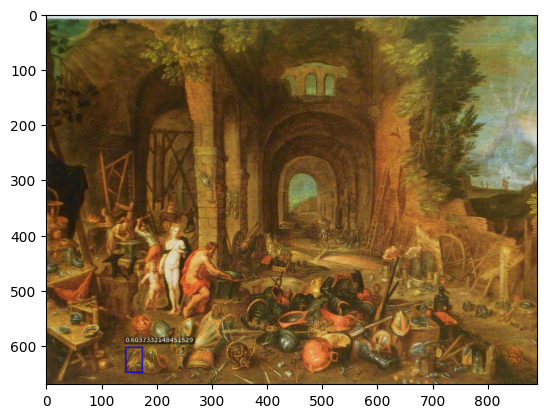

In [19]:
i=cv2.imread('/home/annab/Durham2024/match.png', -1)
plt.imshow(cv2.cvtColor(i, cv2.COLOR_BGR2RGB))
cv2.imwrite('query.png', i)